In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### 패키지 설치 & 라이브러리 import

In [1]:
!pip install optuna
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [3]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [4]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [5]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [6]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [7]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(df, test_size=0.2, val_size=0.25):

    #Train, Test 분류
    train_val_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

    #Train, Validation 분류
    train_df, val_df = train_test_split(train_val_df, test_size=val_size, shuffle=False)

    # # 데이터 크기 출력
    # print("Train set:", train_df.shape)
    # print("Validation set:", val_df.shape)
    # print("Test set:", test_df.shape)

    return train_df, val_df, test_df

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [8]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# splited 데이터 경로 시각화 함수
def plot_trajectory(train_data, val_data, test_data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 훈련 데이터 플롯
    ax.plot(train_data['lat'], train_data['lon'], train_data['alt'], label='Train', color='blue')

    # 검증 데이터 플롯
    ax.plot(val_data['lat'], val_data['lon'], val_data['alt'], label='Validation', color='green')

    # 테스트 데이터 플롯
    ax.plot(test_data['lat'], test_data['lon'], test_data['alt'], label='Test', color='red')

    # 그래프 레이블
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 제목과 범례
    ax.set_title('Drone Trajectory: Train, Validation, and Test')
    ax.legend()

    plt.show()


### 7. 데이터로더 생성 함수

- 학습에 사용할 데이터 로더 생성
1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader 생성

In [10]:
# 데이터 로더 생성 함수
def create_dataloaders(tri, batch_size, sequence_length):

  tri = tri[['time', 'lat', 'lon', 'alt']]

  # train, validation, test 분리
  train_df, val_df, test_df = split_train_val_test(tri[['lat', 'lon', 'alt']])

  # 각 데이터에 대해 시퀀스 생성
  train_x, train_y = create_sequences(train_df, sequence_length)
  val_x, val_y = create_sequences(val_df, sequence_length)
  test_x, test_y = create_sequences(test_df, sequence_length)

  X_train = torch.tensor(train_x, dtype=torch.float32)
  y_train = torch.tensor(train_y, dtype=torch.float32)
  X_val = torch.tensor(val_x, dtype=torch.float32)
  y_val = torch.tensor(val_y, dtype=torch.float32)
  X_test = torch.tensor(test_x, dtype=torch.float32)
  y_test = torch.tensor(test_y, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

## 전처리

### 1. 데이터셋 가져오기

In [11]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [12]:
tri = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lat'])
new_x, lon = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' lon'])
new_x, alt = spline_interpolation(tri['Timpstemp'] / 1e6 , tri[' alt'])

tri = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

tri = truncation(tri)
scaler, tri = min_max_scaling(tri)
# tri

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- Transformer를 사용한 모델 클래스 선언
- 구조 : Transformer + Positional Encoding + Fully Connected Layer

In [13]:
import math
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


In [14]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # input_dim에서 d_model로 변환
        self.positional_encoding = PositionalEncoding(d_model)  # 포지셔널 인코딩 추가
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=0.0 ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(d_model, input_dim)  # d_model에서 input_dim으로 변환

    def forward(self, src):
        src = self.embedding(src)  # 입력 차원 -> d_model로 변환
        src = self.positional_encoding(src)
        src = src.permute(1, 0, 2)  # (batch_size, seq_length, d_model) -> (seq_length, batch_size, d_model)
        output = self.transformer_encoder(src)  # Transformer Encoder 통과
        output = self.fc_out(output)  # (seq_length, batch_size, d_model) -> (seq_length, batch_size, input_dim)

        # 마지막 시점의 출력만 반환
        return output[-1, :, :]  # shape: (batch_size, input_dim)


## 하이퍼파라미터 탐색

### 1. Optuna의 objective 함수 선언

- 최적의 하이퍼파라미터 탐색을 위해 optuna 사용
- objective 함수 선언

In [ ]:
import optuna

def objective(trial, tri, sequence_length):
    # 탐색할 하이퍼파라미터 값 결정
    nhead = trial.suggest_int('nhead', 2, 8)
    d_model = trial.suggest_int('d_model', nhead * 8, nhead * 64, step=nhead) # d_model을 nhead의 배수로 설정하여 짝수 보장
    if d_model % 2 != 0:     # d_model이 홀수인 경우 짝수로 조정
        d_model += 1

    if d_model % nhead != 0: # d_model이 nhead의 배수가 아닌 경우 강제로 배수로 조정
        d_model += nhead - (d_model % nhead)

    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    num_epochs = 300
    intput_size = 3

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 데이터셋 로더
    train_loader, val_loader, _ = create_dataloaders(tri, batch_size, sequence_length)

    # 모델 정의: Transformer Model
    model = TransformerModel(
        input_dim=intput_size,
        seq_length=sequence_length,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward
    ).to(device)  # GPU 사용

    # 손실 함수
    criterion = nn.MSELoss()

    # 최적화 함수
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_val_loss = 0.0  # 모든 epoch에서의 validation loss의 합
    val_loss_count = 0    # 평균을 계산하기 위한 epoch 수

    # 모델 학습
    for epoch in range(num_epochs):
        # Train set으로 학습
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터도 GPU로 이동
            optimizer.zero_grad()
            output = model(batch_X)  # 출력 형태: (batch_size, input_dim)

            # Loss 계산
            loss = criterion(output, batch_y)  # y의 형태: (batch_size, input_dim)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation set에서 성능 측정
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)

                # Loss 계산
                loss = criterion(output, batch_y)
                val_loss += loss.item()

        # 배치 수로 나눠서 평균 validation 손실 계산
        val_loss_avg = val_loss / len(val_loader)

        # Optuna에 중간 값 보고
        trial.report(val_loss_avg, epoch)

        # 총 validation 손실 계산
        total_val_loss += val_loss_avg
        val_loss_count += 1

        # Pruning 조건 확인
        if trial.should_prune():
            print(f"Trial {trial.number} pruned at epoch {epoch}")
            print(f"Validation Loss at prune: {val_loss_avg:.4f}")  # Prune 시점에서 validation loss 출력

            raise optuna.TrialPruned()

    # 모든 epoch에서의 validation Loss avg 반환
    return total_val_loss / val_loss_count

### 3. 탐색 범위 외의 하이퍼파라미터 선언

In [ ]:
sequence_length = 10
early_stopping_rounds = 10
n_trials = 100

### 4. 하이퍼 파라미터 탐색

In [ ]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, tri, sequence_length), n_trials=n_trials)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-10-07 07:16:23,929] A new study created in memory with name: no-name-f3dc5ca8-3924-460a-bcc6-e582879ee3ec
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:17:47,250] Trial 0 finished with value: 0.0006438341001942011 and parameters: {'nhead': 7, 'd_model': 182, 'num_encoder_layers': 3, 'dim_feedforward': 227, 'learning_rate': 0.0010628763419017358, 'batch_size': 128}. Best is trial 0 with value: 0.0006438341001942011.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use

Trial 5 pruned at epoch 1
Validation Loss at prune: 0.0070


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:25:20,519] Trial 6 pruned. 


Trial 6 pruned at epoch 0
Validation Loss at prune: 0.0892


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:25:21,988] Trial 7 pruned. 


Trial 7 pruned at epoch 0
Validation Loss at prune: 0.1661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:32,920] Trial 8 finished with value: 0.00010919231935576146 and parameters: {'nhead': 2, 'd_model': 110, 'num_encoder_layers': 1, 'dim_feedforward': 277, 'learning_rate': 0.0003447120426190648, 'batch_size': 64}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 9 pruned at epoch 1
Validation Loss at prune: 0.0052


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:35,897] Trial 10 pruned. 


Trial 10 pruned at epoch 2
Validation Loss at prune: 0.0022


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:36,679] Trial 11 pruned. 


Trial 11 pruned at epoch 1
Validation Loss at prune: 0.0060


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:39,278] Trial 12 pruned. 


Trial 12 pruned at epoch 5
Validation Loss at prune: 0.0009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:40,287] Trial 13 pruned. 


Trial 13 pruned at epoch 0
Validation Loss at prune: 0.1443


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:26:41,638] Trial 14 pruned. 


Trial 14 pruned at epoch 2
Validation Loss at prune: 0.0015


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:29:09,822] Trial 15 finished with value: 0.00014041886968671263 and parameters: {'nhead': 8, 'd_model': 296, 'num_encoder_layers': 2, 'dim_feedforward': 301, 'learning_rate': 0.00016773257696154966, 'batch_size': 43}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nes

Trial 16 pruned at epoch 6
Validation Loss at prune: 0.0013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:29:13,985] Trial 17 pruned. 


Trial 17 pruned at epoch 0
Validation Loss at prune: 0.1919


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:30:40,172] Trial 18 finished with value: 0.0003093308361359382 and parameters: {'nhead': 4, 'd_model': 100, 'num_encoder_layers': 1, 'dim_feedforward': 183, 'learning_rate': 0.003126769059737577, 'batch_size': 51}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested

Trial 19 pruned at epoch 130
Validation Loss at prune: 0.0001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:32:06,974] Trial 20 pruned. 


Trial 20 pruned at epoch 10
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:32:07,864] Trial 21 pruned. 


Trial 21 pruned at epoch 1
Validation Loss at prune: 0.0051


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:32:08,698] Trial 22 pruned. 


Trial 22 pruned at epoch 0
Validation Loss at prune: 0.0502


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:33:10,718] Trial 23 pruned. 


Trial 23 pruned at epoch 70
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:33:45,192] Trial 24 pruned. 


Trial 24 pruned at epoch 89
Validation Loss at prune: 0.0006


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:33:45,989] Trial 25 pruned. 


Trial 25 pruned at epoch 0
Validation Loss at prune: 0.0279


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:33:47,420] Trial 26 pruned. 


Trial 26 pruned at epoch 4
Validation Loss at prune: 0.0008


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:34:01,969] Trial 27 pruned. 


Trial 27 pruned at epoch 18
Validation Loss at prune: 0.0003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:37:23,428] Trial 28 finished with value: 0.00013328298072450538 and parameters: {'nhead': 4, 'd_model': 164, 'num_encoder_layers': 2, 'dim_feedforward': 385, 'learning_rate': 0.00029354207651968776, 'batch_size': 31}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nes

Trial 33 pruned at epoch 1
Validation Loss at prune: 0.0006


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:53:20,271] Trial 34 pruned. 


Trial 34 pruned at epoch 1
Validation Loss at prune: 0.0007


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:53:21,210] Trial 35 pruned. 


Trial 35 pruned at epoch 0
Validation Loss at prune: 0.0092


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:45,963] Trial 36 pruned. 


Trial 36 pruned at epoch 103
Validation Loss at prune: 0.0003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:46,558] Trial 37 pruned. 


Trial 37 pruned at epoch 0
Validation Loss at prune: 0.1121


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:48,251] Trial 38 pruned. 


Trial 38 pruned at epoch 1
Validation Loss at prune: 0.0008


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:49,280] Trial 39 pruned. 


Trial 39 pruned at epoch 0
Validation Loss at prune: 0.0596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:50,171] Trial 40 pruned. 


Trial 40 pruned at epoch 0
Validation Loss at prune: 0.0045


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:54:53,585] Trial 41 pruned. 


Trial 41 pruned at epoch 1
Validation Loss at prune: 0.0007


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 07:59:41,045] Trial 42 finished with value: 0.00021532190097596008 and parameters: {'nhead': 3, 'd_model': 150, 'num_encoder_layers': 2, 'dim_feedforward': 263, 'learning_rate': 0.00028131154036344726, 'batch_size': 21}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nes

Trial 44 pruned at epoch 0
Validation Loss at prune: 0.1101


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:05:54,011] Trial 45 pruned. 


Trial 45 pruned at epoch 0
Validation Loss at prune: 0.0022


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:06:00,431] Trial 46 pruned. 


Trial 46 pruned at epoch 6
Validation Loss at prune: 0.0003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:06:01,084] Trial 47 pruned. 


Trial 47 pruned at epoch 0
Validation Loss at prune: 0.1596


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:06:02,069] Trial 48 pruned. 


Trial 48 pruned at epoch 0
Validation Loss at prune: 0.0069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:06:03,090] Trial 49 pruned. 


Trial 49 pruned at epoch 0
Validation Loss at prune: 0.0031


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:06:03,725] Trial 50 pruned. 


Trial 50 pruned at epoch 0
Validation Loss at prune: 0.0958


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:09:28,578] Trial 51 finished with value: 0.00012162886693317898 and parameters: {'nhead': 2, 'd_model': 90, 'num_encoder_layers': 2, 'dim_feedforward': 128, 'learning_rate': 0.0009565205953281017, 'batch_size': 30}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 52 pruned at epoch 3
Validation Loss at prune: 0.0005


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:34,526] Trial 53 finished with value: 0.00011287842317326498 and parameters: {'nhead': 3, 'd_model': 105, 'num_encoder_layers': 2, 'dim_feedforward': 154, 'learning_rate': 0.0005344300720766331, 'batch_size': 25}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nest

Trial 54 pruned at epoch 0
Validation Loss at prune: 0.0013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:36,377] Trial 55 pruned. 


Trial 55 pruned at epoch 0
Validation Loss at prune: 0.0036


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:37,377] Trial 56 pruned. 


Trial 56 pruned at epoch 0
Validation Loss at prune: 0.0162


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:38,009] Trial 57 pruned. 


Trial 57 pruned at epoch 0
Validation Loss at prune: 0.0113


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:38,483] Trial 58 pruned. 


Trial 58 pruned at epoch 0
Validation Loss at prune: 0.0419


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:39,150] Trial 59 pruned. 


Trial 59 pruned at epoch 0
Validation Loss at prune: 0.0932


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:13:39,803] Trial 60 pruned. 


Trial 60 pruned at epoch 0
Validation Loss at prune: 0.0293


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:15:33,872] Trial 61 pruned. 


Trial 61 pruned at epoch 108
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:20:04,688] Trial 62 finished with value: 0.00013139642739712189 and parameters: {'nhead': 3, 'd_model': 81, 'num_encoder_layers': 2, 'dim_feedforward': 320, 'learning_rate': 0.0003950149677625295, 'batch_size': 22}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 64 pruned at epoch 0
Validation Loss at prune: 0.0012


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:33,648] Trial 65 finished with value: 0.00014245941085157284 and parameters: {'nhead': 3, 'd_model': 78, 'num_encoder_layers': 2, 'dim_feedforward': 316, 'learning_rate': 0.0004463105777637852, 'batch_size': 20}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 66 pruned at epoch 0
Validation Loss at prune: 0.0027


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:35,536] Trial 67 pruned. 


Trial 67 pruned at epoch 0
Validation Loss at prune: 0.0060


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:36,867] Trial 68 pruned. 


Trial 68 pruned at epoch 0
Validation Loss at prune: 0.1161


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:37,954] Trial 69 pruned. 


Trial 69 pruned at epoch 0
Validation Loss at prune: 0.0051


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:38,565] Trial 70 pruned. 


Trial 70 pruned at epoch 0
Validation Loss at prune: 0.0526


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:40,557] Trial 71 pruned. 


Trial 71 pruned at epoch 1
Validation Loss at prune: 0.0016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:41,416] Trial 72 pruned. 


Trial 72 pruned at epoch 0
Validation Loss at prune: 0.0011


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:42,364] Trial 73 pruned. 


Trial 73 pruned at epoch 0
Validation Loss at prune: 0.0019


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:29:43,458] Trial 74 pruned. 


Trial 74 pruned at epoch 0
Validation Loss at prune: 0.0205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:34:59,201] Trial 75 finished with value: 0.0001466223030058279 and parameters: {'nhead': 2, 'd_model': 88, 'num_encoder_layers': 2, 'dim_feedforward': 173, 'learning_rate': 0.0002638583841431142, 'batch_size': 20}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested

Trial 76 pruned at epoch 0
Validation Loss at prune: 0.0204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:00,740] Trial 77 pruned. 


Trial 77 pruned at epoch 0
Validation Loss at prune: 0.0039


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:01,725] Trial 78 pruned. 


Trial 78 pruned at epoch 0
Validation Loss at prune: 0.0009


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:03,246] Trial 79 pruned. 


Trial 79 pruned at epoch 0
Validation Loss at prune: 0.0010


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:03,943] Trial 80 pruned. 


Trial 80 pruned at epoch 0
Validation Loss at prune: 0.0367


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:05,506] Trial 81 pruned. 


Trial 81 pruned at epoch 0
Validation Loss at prune: 0.0018


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:07,333] Trial 82 pruned. 


Trial 82 pruned at epoch 0
Validation Loss at prune: 0.0013


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:35:08,829] Trial 83 pruned. 


Trial 83 pruned at epoch 0
Validation Loss at prune: 0.0011


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:38:58,038] Trial 84 finished with value: 0.00013855843799188066 and parameters: {'nhead': 3, 'd_model': 96, 'num_encoder_layers': 2, 'dim_feedforward': 372, 'learning_rate': 0.0007506827559845248, 'batch_size': 29}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 86 pruned at epoch 1
Validation Loss at prune: 0.0006


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:42:47,195] Trial 87 pruned. 


Trial 87 pruned at epoch 0
Validation Loss at prune: 0.0104


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:42:48,091] Trial 88 pruned. 


Trial 88 pruned at epoch 0
Validation Loss at prune: 0.0089


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:42:52,775] Trial 89 pruned. 


Trial 89 pruned at epoch 2
Validation Loss at prune: 0.0004


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:42:53,480] Trial 90 pruned. 


Trial 90 pruned at epoch 0
Validation Loss at prune: 0.0163


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:42:54,694] Trial 91 pruned. 


Trial 91 pruned at epoch 0
Validation Loss at prune: 0.0015


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:47:58,175] Trial 92 finished with value: 0.00022735791481844338 and parameters: {'nhead': 3, 'd_model': 81, 'num_encoder_layers': 2, 'dim_feedforward': 308, 'learning_rate': 0.0005219554763148627, 'batch_size': 20}. Best is trial 8 with value: 0.00010919231935576146.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

Trial 93 pruned at epoch 0
Validation Loss at prune: 0.0039


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:01,282] Trial 94 pruned. 


Trial 94 pruned at epoch 0
Validation Loss at prune: 0.0038


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:02,211] Trial 95 pruned. 


Trial 95 pruned at epoch 0
Validation Loss at prune: 0.0018


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:02,886] Trial 96 pruned. 


Trial 96 pruned at epoch 0
Validation Loss at prune: 0.0190


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:03,665] Trial 97 pruned. 


Trial 97 pruned at epoch 0
Validation Loss at prune: 0.0198


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:04,830] Trial 98 pruned. 


Trial 98 pruned at epoch 0
Validation Loss at prune: 0.0017


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[I 2024-10-07 08:48:06,908] Trial 99 pruned. 


Trial 99 pruned at epoch 1
Validation Loss at prune: 0.0005
Best hyperparameters:  {'nhead': 2, 'd_model': 110, 'num_encoder_layers': 1, 'dim_feedforward': 277, 'learning_rate': 0.0003447120426190648, 'batch_size': 64}


### 5. 하이퍼파라미터 저장

In [ ]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


## 학습

### 1. 하이퍼파라미터 불러오기

In [15]:
import json

# 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'nhead': 2, 'd_model': 110, 'num_encoder_layers': 1, 'dim_feedforward': 277, 'learning_rate': 0.0003447120426190648, 'batch_size': 64}


### 2. 최적의 파라미터로 모델 학습

In [16]:
sequence_length = 10
num_epochs = 300

In [17]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = create_dataloaders(tri, best_params['batch_size'], sequence_length)

best_model = TransformerModel(
    input_dim=3,
    seq_length=10,
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward']
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

train_losses = [] # 손실 저장할 리스트
val_losses = []

for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 입력 데이터 차원 조정
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")

# Model Save
model_save_path = f"best_model_with_losses.pth"
torch.save({
    'model_state_dict': best_model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
    }, model_save_path)
print(f"Model saved: {model_save_path}")


Epoch [1/300], Train Loss: 2.8468, Val Loss: 0.8876
Epoch 1/300 completed in 1.10 seconds.
Epoch [2/300], Train Loss: 0.2618, Val Loss: 0.0284
Epoch 2/300 completed in 0.99 seconds.
Epoch [3/300], Train Loss: 0.0372, Val Loss: 0.0100
Epoch 3/300 completed in 0.98 seconds.
Epoch [4/300], Train Loss: 0.0138, Val Loss: 0.0080
Epoch 4/300 completed in 0.98 seconds.
Epoch [5/300], Train Loss: 0.0104, Val Loss: 0.0058
Epoch 5/300 completed in 0.97 seconds.
Epoch [6/300], Train Loss: 0.0090, Val Loss: 0.0052
Epoch 6/300 completed in 1.13 seconds.
Epoch [7/300], Train Loss: 0.0086, Val Loss: 0.0051
Epoch 7/300 completed in 1.47 seconds.
Epoch [8/300], Train Loss: 0.0077, Val Loss: 0.0045
Epoch 8/300 completed in 1.47 seconds.
Epoch [9/300], Train Loss: 0.0073, Val Loss: 0.0041
Epoch 9/300 completed in 0.98 seconds.
Epoch [10/300], Train Loss: 0.0069, Val Loss: 0.0051
Epoch 10/300 completed in 0.96 seconds.
Epoch [11/300], Train Loss: 0.0064, Val Loss: 0.0044
Epoch 11/300 completed in 0.97 seco

### 3. 모델 요약 내용 출력

In [19]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 3]                    --
├─Linear: 1-1                                 [1, 10, 110]              440
├─PositionalEncoding: 1-2                     [1, 10, 110]              --
├─TransformerEncoder: 1-3                     [10, 1, 110]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [10, 1, 110]              110,607
├─Linear: 1-4                                 [10, 1, 3]                333
Total params: 111,380
Trainable params: 111,380
Non-trainable params: 0
Total mult-adds (M): 0.62
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

## 테스트

### 1. 테스트 결과 생성

In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 2.6661136871553026e-05
Mean Absolute Error (MAE): 0.0035849492996931076


### 2. 결과 시각화

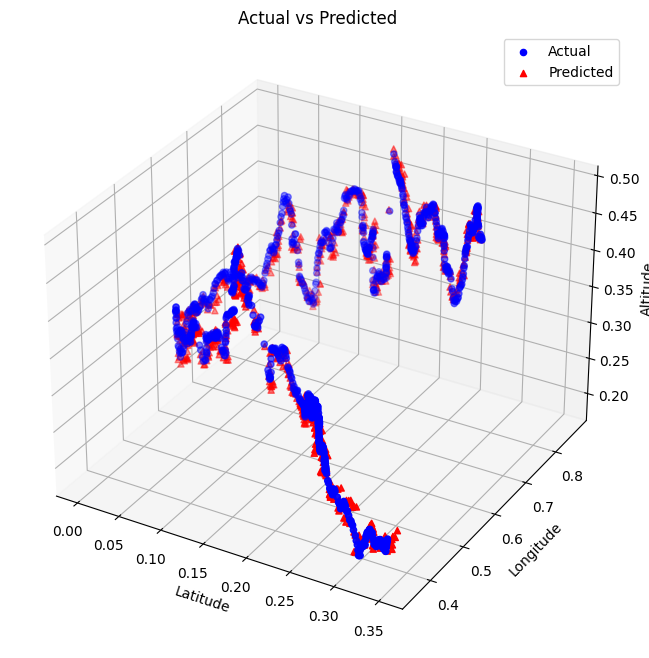

In [25]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

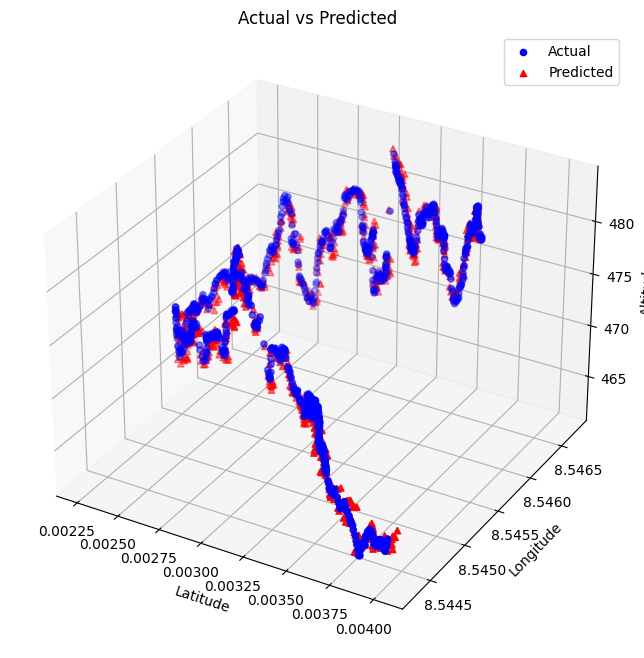

In [26]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

In [28]:
# plot_trajectory(train_data, val_data, test_data)

## Compare Models


### Model 비교 그래프

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison(df, num_epochs, y_limits = [0, 0.01]):

    # 그래프 설정
    if num_epochs == 50:
        xticks_interval = 10
    elif num_epochs == 100:
        xticks_interval = 20
    elif num_epochs == 150:
        xticks_interval = 30
    else:
        xticks_interval = num_epochs // 5  # 에포크 수에 따라 5개로 구분

    # 색상 지정
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    sns.set(style="whitegrid")

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot Train Loss
    axs[0].plot(df['epoch'], df['train_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[0].plot(df['epoch'], df['train_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[0].set_title('Train Loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(range(0, num_epochs + 1, xticks_interval))  # x축 tick 설정
    axs[0].legend()
    axs[0].yaxis.grid(False)  # 가로줄 끄기
    axs[0].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[0].set_ylim(y_limits[0], y_limits[1])

    # Plot Valid Loss
    axs[1].plot(df['epoch'], df['valid_loss_1'], label='LSTM', color=colors[0], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_2'], label='GRU', color=colors[1], marker='o', markevery=[-1])
    axs[1].plot(df['epoch'], df['valid_loss_3'], label='Transformer', color=colors[2], marker='o', markevery=[-1])
    axs[1].set_title('Valid Loss')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xticks(range(0, num_epochs + 1, xticks_interval))
    axs[1].legend()
    axs[1].yaxis.grid(False)  # 가로줄 끄기
    axs[1].xaxis.grid(False)  # 세로줄 끄기

    # Y축 수동 설정
    if y_limits:
        axs[1].set_ylim(y_limits[0], y_limits[1])

    # Adjust layout
    plt.tight_layout()
    plt.show()

### 모델 불러오기

In [44]:
checkpoint = torch.load('best_model_with_losses.pth')
print(checkpoint.keys())

transformer_train_losses = checkpoint['train_losses']
transformer_val_losses = checkpoint['val_losses']

# 손실 값 확인
# print(f"Train Losses: {transformer_train_losses[:5]}")
# print(f"Validation Losses: {transformer_val_losses[:5]}")

dict_keys(['model_state_dict', 'train_losses', 'val_losses'])


<ipython-input-44-9b5fd5000049>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_with_losses.pth')


### Val, Test data LOSS

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_losses(train_losses, val_losses, y_limits=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Y축 수동 설정 (옵션)
    if y_limits:
        plt.ylim(y_limits[0], y_limits[1])

    plt.plot(epochs, train_losses, label='Training Loss', color='b')
    plt.plot(epochs, val_losses, label='Validation Loss', color='r')

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss per Epoch', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.show()


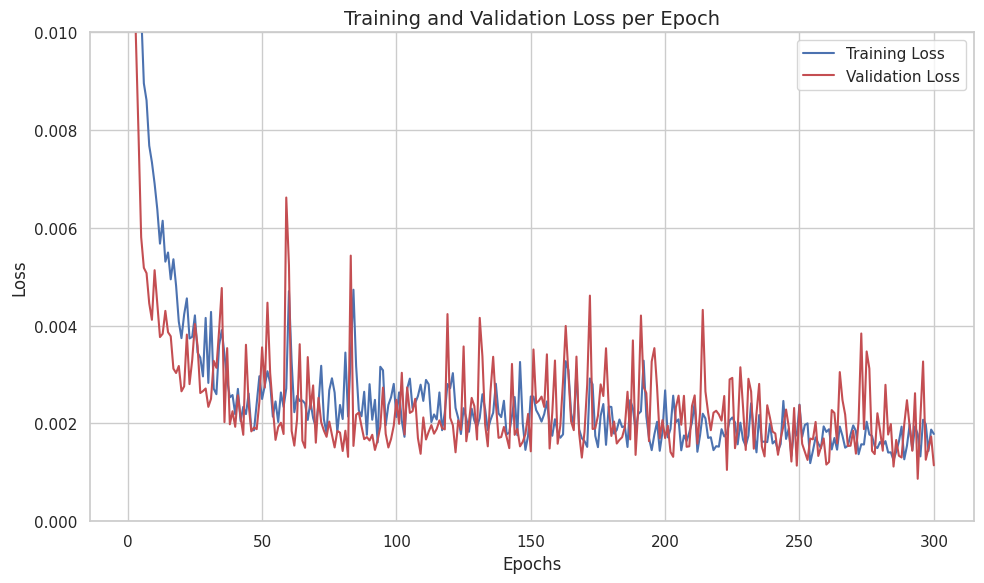

In [91]:
plot_losses(transformer_train_losses, transformer_val_losses, y_limits = (0, 0.01))


### 데이터 수집

In [92]:
data = {
    'epoch': list(range(1, num_epochs + 1)),  # 실제 에포크 수만큼
    'train_loss_1': [x * 1.3 for x in train_losses],
    'train_loss_2': [x * 0.2 for x in train_losses],
    'train_loss_3': transformer_train_losses,
    'valid_loss_1': [x * 1.3 for x in val_losses],
    'valid_loss_2': [x * 0 for x in val_losses],
    'valid_loss_3': transformer_val_losses
}

### 모델 비교 그래프 그리기

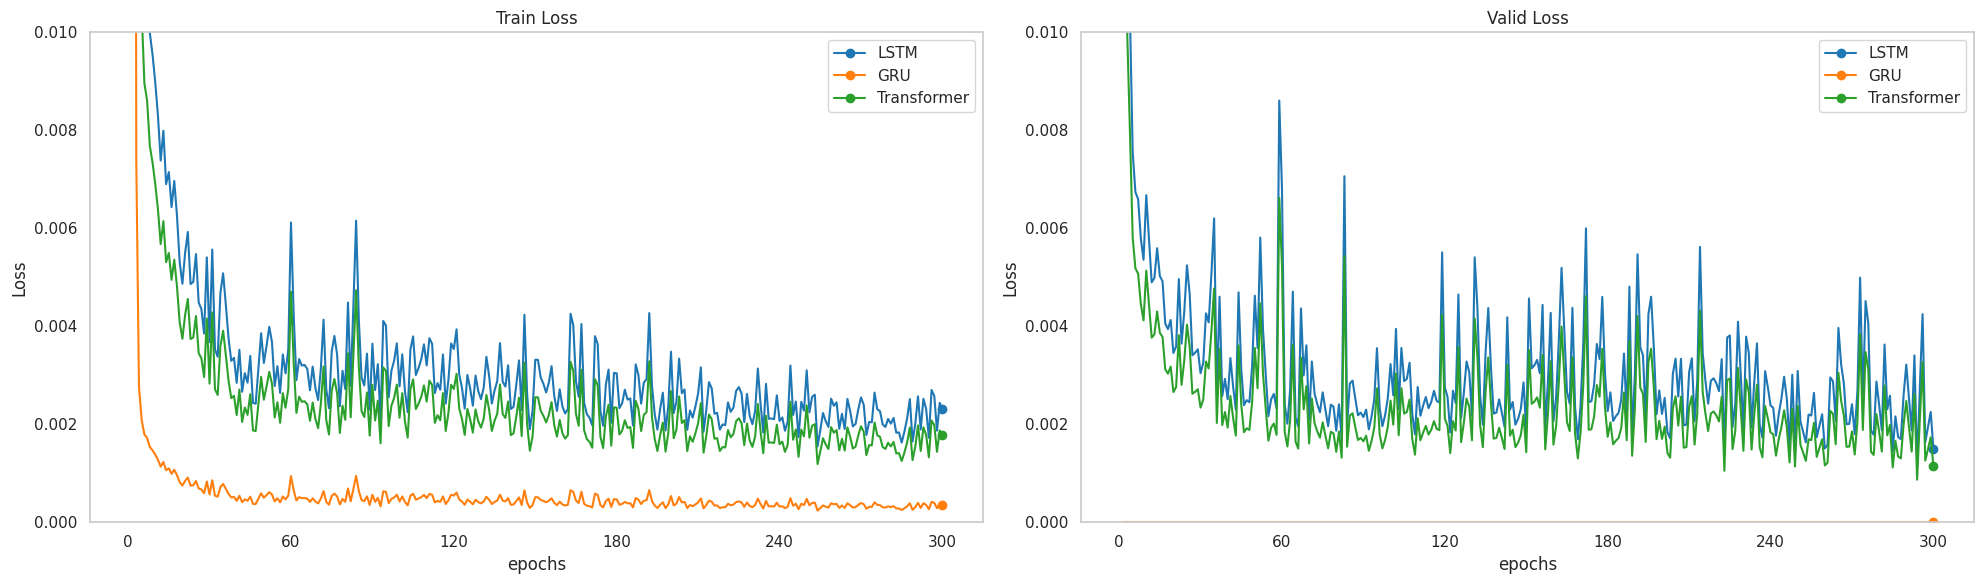

In [93]:
df = pd.DataFrame(data)

# 그래프 그리기
plot_model_comparison(df, num_epochs)